<a href="https://colab.research.google.com/github/g7an/artificial_intelligence/blob/main/shortest_path_campus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h1> Search Agents </h1> </center>

In this homework, we will implement  a search agent.

More specifically, we will:
1. Implement breadth-first search algorithm.
2. Implement depth-first algorithm (optional).
3. Implement Uniform-cost search algorithm (optional).
3. Apply these algorithms to find a  path on a map between two points.

<center> <h2> Setup </h2> </center>

#### Google colaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This is a neat python environment that works in the cloud and does not require you to
set up anything on your personal machine
(it also has some built-in IDE features that make writing code easier).
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people. In this homework, we will ask you to copy current colaboraty,
complete all the tasks and share your colaboratory notebook with us so
that we can grade it. We will also use colaboratory for the homework #4 so this
homework will prepare you for it.


#### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write/change/uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected.
5. Paste the link into your submission pdf file so that we can view it and grade.

<center> <h2> Installing dependencies </h2> </center>

Below we will download the map object containing graph representation of homewood campus, download python library that you will use to get interactive visualization of search algorithms and install some python dependecies.

Be careful, if you leave your notebook without use for a long time, all the downloaded and installed libraries will be lost -- so you will have to repeat the download and pip-install again.

In [ ]:
!wget https://www.dropbox.com/s/i95ypee2s3ylg68/hopkins_homewood_graph.graph

In [ ]:
!wget https://www.dropbox.com/s/0wwaym9pmdtrxt4/ai_hw2_lib.py

In [ ]:
pip install geopandas

<center> <h2> Map Graph </h2> </center>

Our map is represented as a graph object. We are using networx library for that.
It is not necessary to be able to use the library, but we refer those who are interested to the following tutorial:

https://networkx.github.io/documentation/stable/tutorial.html

After reading the graph object we are plotting the graph so that we can see nodes and edges between them. In this homework we will implement search algorithms to find paths between some nodes.

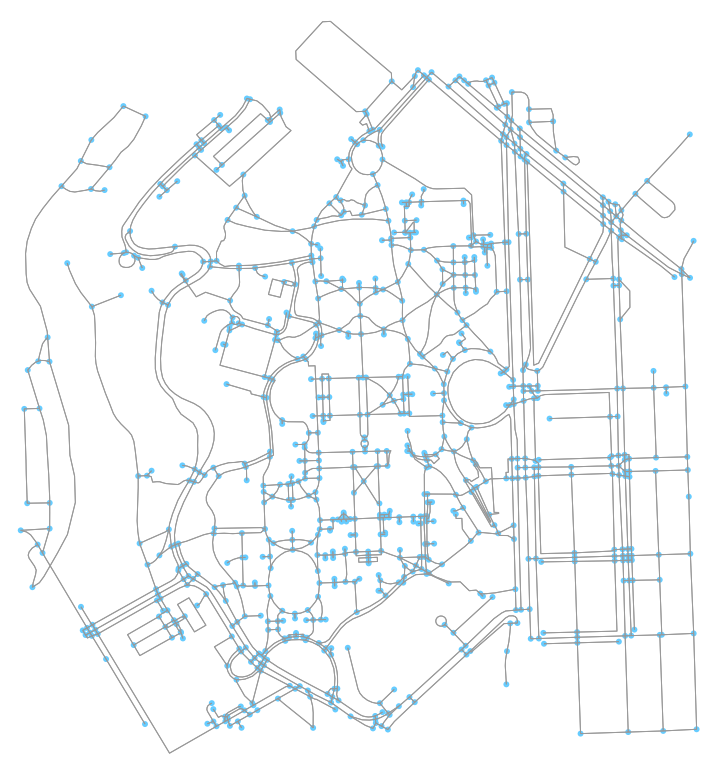

(<Figure size 907.007x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feb197fd860>)

In [ ]:
from ai_hw2_lib import plot_graph, plot_graph_route

import pickle
import networkx as nx


with open('hopkins_homewood_graph.graph', 'rb') as file:
    
    graph = pickle.load(file)

    
plot_graph(graph, fig_height=14, dpi=700, node_size=35)

<center> <h2> Search Tree </h2> </center>

Search algorithms require a data structure to keep track of the search tree that is being constructed. For each node of the tree, we have a data structure that contains components:

1. State -- an integer unique ID of the node of the graph (used by networkx to access nodes).
2. Parent -- a node in the search tree that generated this node. This will be useful for constructing the path during search.
3. Path cost --  a cost associated with current node.

Moreover, you can use methods like ```mark_graph_node_as_start``` to mark the nodes with a certain color so that you can see it on a map during visualization. Call ```clear_map``` function to remove all the marks placed on the map and restore the map to the default view.

In [ ]:
class Node:

    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the state for this node
    representing actual graph node (graph node ID)."""

    def __init__(self, state, parent=None, path_cost=0):
        """Create a search tree Node"""
        self.state = state
        self.parent = parent
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1
    
    def __repr__(self):
      
        return "<Node state={}>".format(self.state)
    
    def expand(self, graph):
        """List the nodes reachable in one step from this node i.e
           neighbours of the current node."""
        
        return [self.child_node(graph, state)
                for state in graph.neighbors(self.state)]
    
    def child_node(self, graph, state):
        """Create a new search node and mark it as a child.
         The child node will have current node as a parent."""
       
        next_node = Node(state,
                         parent=self,
                         path_cost=self.path_cost + 1)
        
        return next_node

    
    def solution(self):
        """Return the sequence of states to go from the root to this node."""
        
        return [node.state for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def __eq__(self, other):
        """Used to compare two nodes. They are considered equal if they have
        the same ID in the original map. So even if you have two different Node
        objects with the same map ID they will be considered the same. This will
        be useful to keep track of explored nodes and frontier nodes to avoid loops."""
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        """This method allows us to store Node objects in the set() which
           will be useful to track visited nodes"""
        return hash(self.state)
    
    def mark_graph_node_as_start(self, graph):
        """This method is used for visualization. By marking the node as a start
         it will be discinctively colored during the graph visualization.
         The node will be marked with Dark Blue color."""
        graph.nodes[self.state]['node_type'] = 'start'
    
    def mark_graph_node_as_destination(self, graph):
        """This method is used for visualization. By marking the node as destination
         it will be discinctively colored during the graph visualization.
         The node will be marked with Red color."""
      
        graph.nodes[self.state]['node_type'] = 'destination'
    
    def mark_graph_node_as_visited(self, graph):
         """This method is used for visualization. By marking the node as visited
         it will be discinctively colored during the graph visualization.
         The node will be marked with Green color."""
      
         graph.nodes[self.state]['node_type'] = 'visited'

    def mark_graph_node_as_frontier(self, graph):
         """This method is used for visualization. By marking the node as frontier
         it will be discinctively colored during the graph visualization.
         The node will be marked as Orange color."""
      
         graph.nodes[self.state]['node_type'] = 'frontier'

        
def clear_map(graph):
  """The function clears all the marks that were placed on the map
  by using the mark_graph_node_as_* functions. Use it if you want to
  restart the search or change the starting and destination points."""

  for node in graph.nodes:

    graph.nodes[node]['node_type'] = None

Now let's create the starting and destination nodes -- we will try to find a path between them.
As mentioned previously we use unique IDs representing the graph nodes. If you want to change the starting and destination nodes you can display the map with IDs displayed near each node and pick the ones that you want (use the commented out line of code below).

We also mark the starting node and destination node with blue and red color respectively and you see them on map now.

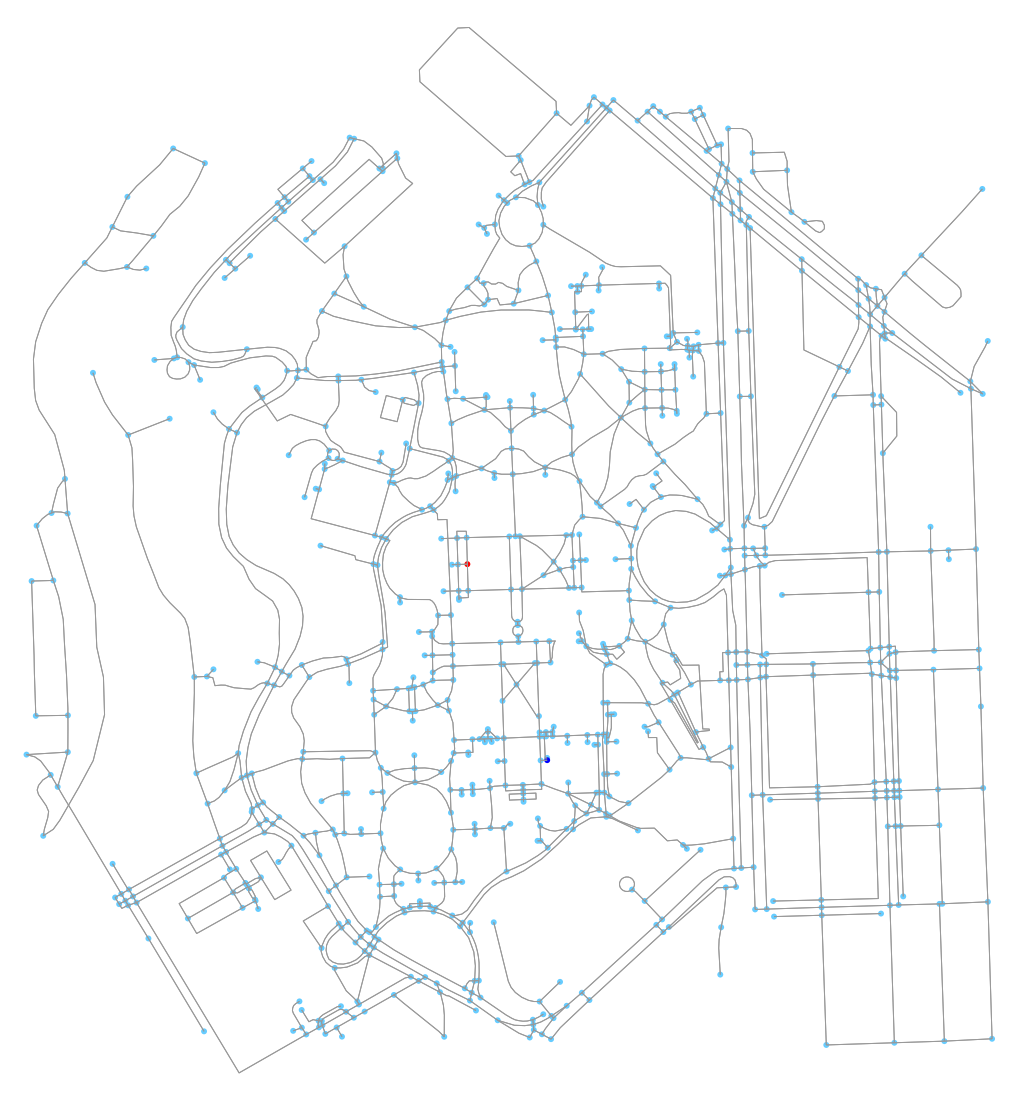

(<Figure size 1295.72x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feb19775e80>)

In [ ]:
# Shaffer Hall
start_graph_state = 2451200795

# Gilman Hall
destination_graph_state = 4519935164


start_node = Node(state=start_graph_state)
destination_node = Node(state=destination_graph_state)

start_node.mark_graph_node_as_start(graph)
destination_node.mark_graph_node_as_destination(graph)

plot_graph(graph, fig_height=20, dpi=700, node_size=35)

# Use the function below if you want to change starting node
# and destination one. The function below will display a huge map with
# numbers displayed on top of each node.
#plot_graph(graph, fig_height=100, dpi=1000, node_size=35, annotate=True)

# Use this to clear the map
#clear_map(graph)

Below we will ask you to implement breadth-first search, but before that we will give you some parts of code that will be useful in your implementation.

Here is a pheudocode:
````
1  procedure BFS(G, start_graph_state):
2      let frontier_queue be a queue
3      let explored_set be a set
4      frontier_queue.enqueue(start_graph_state)
5      while frontier_queue is not empty
6          next_node_to_explore = frontier_queue.dequeue()
7          explored_set.add(next_node_to_explore)
8          for neighbour in G.neighbours(next_node_to_explore)
9              if neighbour is not in frontier_queue and explored_set:
10                  if neighbour is the goal:
11                    return neighbour
12                  else:
13                    frontier_queue.enqueue(neighbour)
````

Here are the python equivalents of set and queue that you will have to use:

In [ ]:
## This cell is not supposed to be executed.
## Borrow parts of code from here to complete tasks in the
## next cells.

### FIFO Queue

# Using list as a FIFO queue
frontier_queue = []

# frontier_queue.enqueue() equivalent -- places a node in the queue
frontier_queue.insert(0, start_node)

# frontier_queue.dequeue() equivalent -- retrieves the next element from the queue
frontier_queue.pop()

# while frontier_queue is not empty equivalent
# This loop will run until the frontier_queue is empty
while frontier_queue:
  
### Set

# let explored_set be a set equivalent
explored_set = set()

# explored_set.add(next_node_to_explore) equivalent
explored_set.add(next_node_to_explore)

# Important -- the set checks the added nodes based on their IDs in the map
# So if you have two tree search nodes pointing to the same map node and you will
# add them to the set, only one element will be in the set.

### Neighbours exploration

# for neighbour in G.neighbours(next_node_to_explore) equivalent
# Returns search tree nodes that are neighbours of the next_node_to_explore
# i.e. has an edge that connects them. Returned elements are automatically marked
# as children of the next_node_to_explore search node.
for neighbor in next_node_to_explore.expand(graph):

  
### Other

# if neighbour is not in frontier_queue and explored_set: equivalents
if neighbor in explored_set:
if neighbor in frontier_queue:


# if neighbour is the goal: equivalent
# Checks if the next neighbour has the same map ID as the one that we
# are searching for
if neighbor == destination_node:

Now implement the function below. We have filled out some parts already.
Implement the rest.

You have two functions -- one will allow you to just get the solution node and another will
also add interactive updates everytime your algorithm explores new nodes until it reaches the goal.

In [ ]:
from IPython.display import display, HTML, clear_output


def breadth_first_search(graph, start_node, destination_node):
  
  # Using list as a queue
  frontier_queue = []

  # Keeping track of explored nodes
  explored_set = set()

  frontier_queue.insert(0, start_node)
  start_node.mark_graph_node_as_frontier(graph)
  
  while frontier_queue:

    # Add code here
    next_node_to_explore.mark_graph_node_as_visited(graph)

    for neighbor in next_node_to_explore.expand(graph):

      # And here

      if neighbor == destination_node:

          return neighbor

      # And here
      neighbor.mark_graph_node_as_frontier(graph)

      
def breadth_first_search_interactive(graph, start_node, destination_node):
  
  # Using list as a queue
  frontier_queue = []

  # Keeping track of explored nodes
  explored_set = set()

  frontier_queue.insert(0, start_node)
  start_node.mark_graph_node_as_frontier(graph)
  clear_output(wait=True)
  plot_graph(graph, fig_height=14, dpi=700, node_size=35)

  while frontier_queue:

    # Add code here
    next_node_to_explore.mark_graph_node_as_visited(graph)
    clear_output(wait=True)
    plot_graph(graph, fig_height=14, dpi=700, node_size=35)

    for neighbor in next_node_to_explore.expand(graph):

      # And here
      
      if neighbor == destination_node:

          return neighbor

      # And here
      
      neighbor.mark_graph_node_as_frontier(graph)
      clear_output(wait=True)
      plot_graph(graph, fig_height=14, dpi=700, node_size=35)

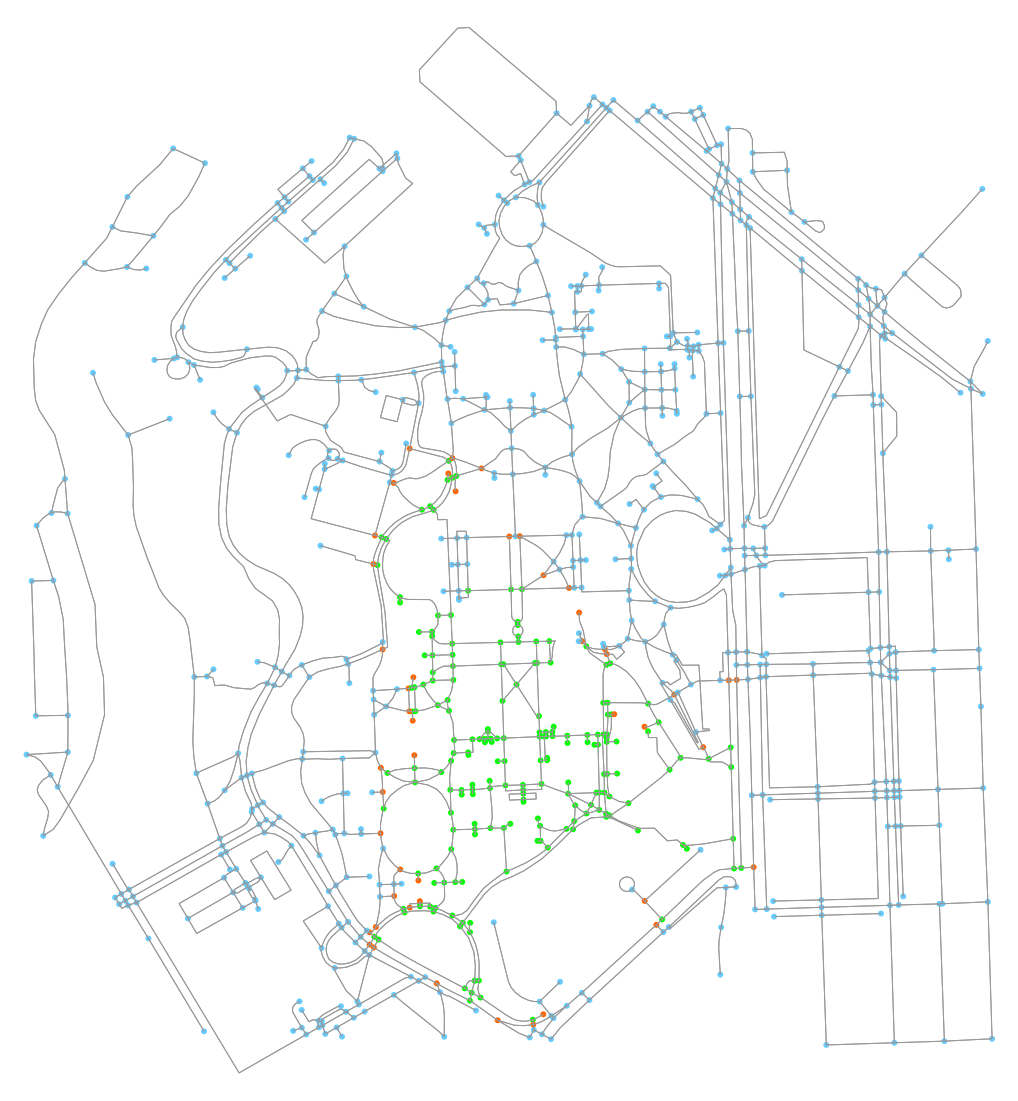

(<Figure size 1295.72x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feb1979a7f0>)

In [ ]:
# This will show all the explored (green) and frontier (orange) nodes
# at the moment when your algorithm found the solution

clear_map(graph)
solution_node = breadth_first_search(graph, start_node, destination_node)
plot_graph(graph, fig_height=20, dpi=700, node_size=35)

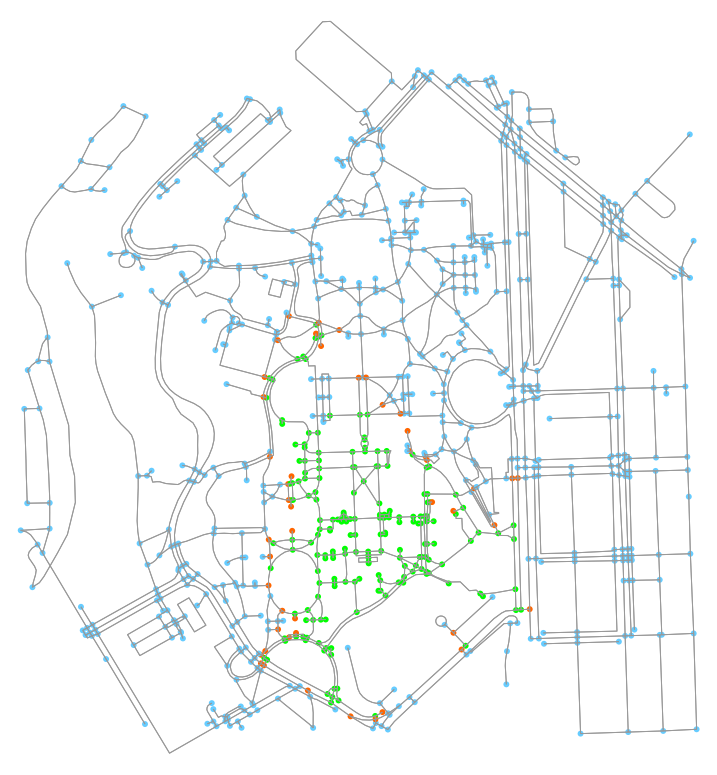

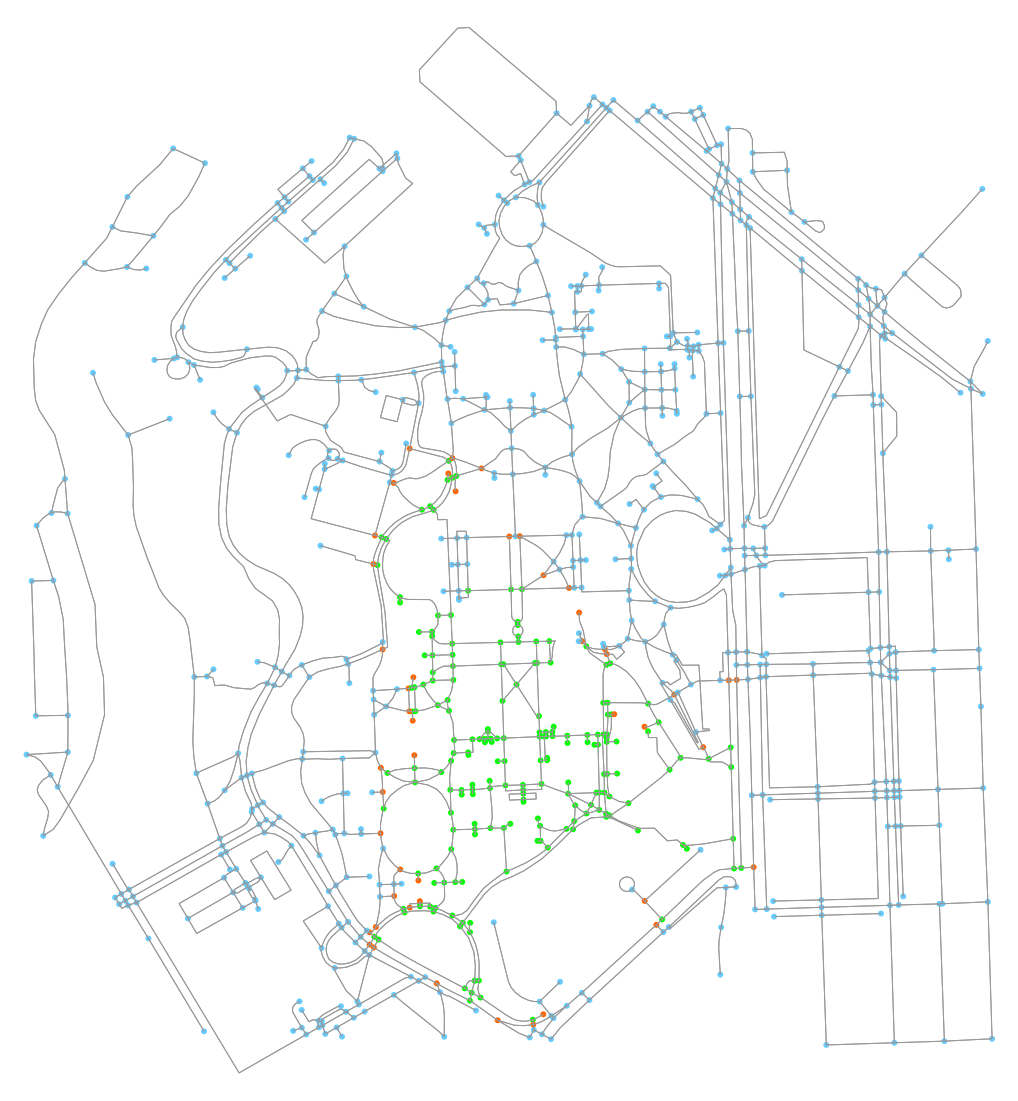

(<Figure size 1295.72x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5767bb2b0>)

In [ ]:
# This will show you the real-time visualization of your algorithm
# when it explores nodes.

# Visualization is slow and we will not require you to show this cell.
# To get credit just show us the solution of the previous cell.

# This cell was made only for learning purposes.

clear_map(graph)
solution_node = breadth_first_search_interactive(graph, start_node, destination_node)

Now let us actually see the path that the algorithm found. We can do this now by taking 
the solution node and tracking it back to root. The ```.solution()``` method returns
the sequence of map IDs that represent the path. In order to get a credit for this task,
make sure to show us the result of this cell and save it. Main part ends here and you can do extra part below if you want.

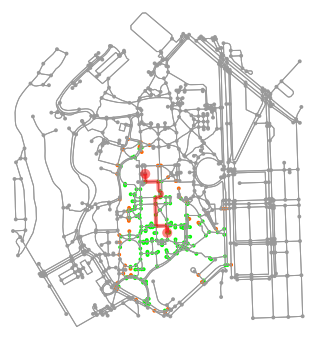

(<Figure size 388.717x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feb15c29a90>)

In [ ]:
plot_graph_route(graph, solution_node.solution())

<center> <h2> Extra </h2> </center>

1. Implement depth-first search algorithm.
2. Implement uniform cost search. You can spot the problem with existing implementation of breadth-first that sometimes it will not give you
shortest path in terms of actual distance (miles instead of number of nodes). In order to find the actual shortest path, implement the Uniform-cost search. You can access the actual distance between two map nodes by using the function ```graph.edges[first_graph_element_id, second_graph_element_id, 0]['length']```